In [1]:
import regex as re
import numpy as np
from statistics import mean, stdev
import matplotlib
import random
import matplotlib.pyplot as plt
#from bento_bench import bar_plot, parse_elapsed_secs, get_avg_from_table_str, set_size
import pandas as pd
import json
import os
import seaborn as sns
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
#     "font.size": 7,
# })

fio_iops_avg_regex = "(?<=^\s*iops\s*: min=\s*\d*, max=\s*\d*, avg=\s*)\d+\.\d*"
fio_iops_stdev_regex = "(?<=^\s*iops\s*: min=\s*\d*, max=\s*\d*, avg=\s*\d*\.*\d*, stdev=)\d+\.\d*"

# Some are in KiB, some in MiB....
fio_bw_kib_avg_regex = "(?<=^\s*bw \(  KiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*)\d+\.\d*"
fio_bw_mib_avg_regex = "(?<=^\s*bw \(  MiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*)\d+\.\d*"
fio_bw_kib_stdev_regex = "(?<=^\s*bw \(  KiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*\d*\.*\d*, stdev=\s*)\d+\.\d*"
fio_bw_mib_stdev_regex = "(?<=^\s*bw \(  MiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*\d*\.*\d*, stdev=\s*)\d+\.\d*"

fio_clat_usec_avg_regex = "(?<=^\s*clat \(usec\): min=\d+, max=\d+, avg=)\d+\.\d*"
fio_clat_nsec_avg_regex = "(?<=^\s*clat \(nsec\): min=\d+, max=\d+, avg=)\d+\.\d*"
fio_clat_usec_stdev_regex = "(?<=^\s*clat \(usec\): min=\d+, max=\d+, avg=\d+\.*\d*, stdev=)\d+\.\d*"
fio_clat_nsec_stdev_regex = "(?<=^\s*clat \(nsec\): min=\d+, max=\d+, avg=\d+\.*\d*, stdev=)\d+\.\d*"

In [2]:
def get_instructions(df):
    return df.loc[df['event'] == 'instructions', ['val']].iloc[0].item()
def get_cpus(df):
    return df.loc[df['event'] == 'cpu-clock', ['metric_val']].iloc[0].item()
def get_cycles(df):
    return df.loc[df['event'] == 'cycles', ['val']].iloc[0].item()
# We assume here that all the events have been measured for an equal amount of time
def get_time_measured(df):
    return df.loc[df['event'] == 'cpu-clock', ['time_measured']].iloc[0].item() / get_cpus(df)
def get_ipc(df):
    return df.loc[df['event'] == 'instructions', ['metric_val']].iloc[0].item()
def get_branches(df):
    return df.loc[df['event'] == 'branches', ['val']].iloc[0].item()
def get_branch_missrate(df):
    return df.loc[df['event'] == 'branch-misses', ['metric_val']].iloc[0].item()
def get_val(df, metric):
    return df.loc[df['event'] == metric, ['val']].iloc[0].item()
def get_l1_dcache_missrate(df):
    return df.loc[df['event'] == 'L1-dcache-load-misses', ['metric_val']].iloc[0].item()
def get_dtlb_missrate(df):
    return df.loc[df['event'] == 'dTLB-loads-misses', ['metric_val']].iloc[0].item()

In [3]:
perf_stat_colnames = [ "val", "unit", "event", "time_measured", "perctage_measured", "metric_val", "metric_unit"]
targets = {
    "NFS": "./nfs/a906294_zac15_2023-02-26_20:26:58/",
    "Virtio-fs": "./nfs/a906294_zac15_2023-02-26_20:26:58/",
}
metrics = ["Instructions/OP", "IPC", "Branch missrate", "L1 dCache missrate", "dTLB missrate"]
# perf time_measured is in nsec
runtime = 600
perf_nrep = 5

perf_load = []
iops = []
table = pd.DataFrame(index=metrics)
for i, (conf, folder) in enumerate(targets.items()):
    T1_iops_l = pd.Series(dtype="float")
    for i in range(1, perf_nrep+1):
        f = open(folder + "cpu_load_T1_fio_" + str(i) + ".out")
        matches = re.findall(fio_iops_avg_regex, f.read(), re.MULTILINE)
        T1_iops_l = pd.concat((T1_iops_l, pd.Series(np.array(matches).astype(float).sum())))
    T1_iops = T1_iops_l.mean()

    perf_baseline = pd.DataFrame(columns=["instructions"])
    for i in range(1, perf_nrep+1):
        f = open(folder + "cpu_baseline_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        f.readline()
        f.readline()
        raw = pd.read_csv(f, names=perf_stat_colnames)
        row = {
            "instructions": get_instructions(raw)
        }
        perf_baseline = pd.concat((perf_baseline, pd.DataFrame([row])), ignore_index=True)

    perf_load = pd.DataFrame(columns=["instructions", "ipc", "branch_missrate"])
    for i in range(1, perf_nrep+1):
        T1_f = open(folder + "cpu_load_T1_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T1_f.readline()
        T1_f.readline()
        T1_raw = pd.read_csv(T1_f, names=perf_stat_colnames)
        T2_f = open(folder + "cpu_load_T2_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T2_f.readline()
        T2_f.readline()
        T2_raw = pd.read_csv(T2_f, names=perf_stat_colnames)
        T3_f = open(folder + "cpu_load_T3_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T3_f.readline()
        T3_f.readline()
        T3_raw = pd.read_csv(T3_f, names=perf_stat_colnames)
        row = {
            "instructions": get_instructions(T1_raw),
            "ipc": get_ipc(T1_raw),
            "branch_missrate": get_branch_missrate(T1_raw),
            "l1": get_l1_dcache_missrate(T2_raw),
            "dtlb": get_dtlb_missrate(T3_raw),
        }
        perf_load = pd.concat((perf_load, pd.DataFrame([row])), ignore_index=True)

    perf_baseline = perf_baseline.mean()
    perf_load = perf_load.mean()
    
    row = {
        metrics[0]: round((perf_load[0] - perf_baseline[0]) / runtime / T1_iops),
        metrics[1]: perf_load[1],
        metrics[2]: perf_load[2],
        metrics[3]: perf_load[3],
        metrics[4]: perf_load[4]
    }
    table = table.join(pd.DataFrame([row]).transpose())
    table = table.rename(columns={ 0: conf })

# testing different values
table.loc['Instructions/OP', 'Virtio-fs'] = 80000
table.loc['IPC', 'Virtio-fs'] = 1.6

table['+/- %'] = (table['NFS'] - table['Virtio-fs']) / table['NFS'] * 100 * -1
    
table = table.round(2).applymap("{0:.2f}".format)
print(table)
table.style.to_latex("cpu_analysis.tex")
#get_branches(perf_load[0]) - get_branches(perf_baseline[0])
#get_branch_misses(perf_load[0]) - get_branch_misses(perf_baseline[0])
#( - get_instructions(perf_baseline[0])) / iops[0]
#
#
#instructions = [
#    get_instructions(perf_baseline[0]) / get_time_measured(perf_baseline[0]) * runtime,
#    get_instructions(perf_load[0]) / get_time_measured(perf_load[0]) * runtime
#]

                         NFS Virtio-fs   +/- %
Instructions/OP     88453.00  80000.00   -9.56
IPC                     0.57      1.60  180.70
Branch missrate         2.02      2.02   -0.00
L1 dCache missrate      8.82      8.82   -0.00
dTLB missrate           0.14      0.14   -0.00


In [4]:
target = "nulldev"
# TODO
folder = "./nfs/a906294_zac15_2023-02-26_20:26:58/"

cols = ["RW", "BS", "QD", "P", "avg", "stdev"]

iops = pd.DataFrame(columns=cols)
clat = pd.DataFrame(columns=cols)
bw = pd.DataFrame(columns=cols)

for rw in ["randread", "randwrite"]:
    for bs in ["1", "4k", "8k", "16k", "32k", "64k", "128k"]:
        for qd in ["1", "2", "4", "8", "16", "32", "64", "128"]:
            p="2"
            path = "fio_" + rw + "_" + bs + "_" + qd + "_" + p + ".out"
            f = open(folder + path)
            f_buf = f.read()

            # IOPS
            avg_matches = re.findall(fio_iops_avg_regex, f_buf, re.MULTILINE)
            stdev_matches = re.findall(fio_iops_stdev_regex, f_buf, re.MULTILINE)
            row = {
                "RW": rw,
                "BS": bs,
                "QD": qd,
                "P": p,
                "avg": np.array(avg_matches).astype(float)[0],
                "stdev": np.array(stdev_matches).astype(float)[0]
            }
            iops = pd.concat((iops, pd.DataFrame([row])), ignore_index=True)
            
            # Completion latency
            avg_matches = np.array(re.findall(fio_clat_usec_avg_regex, f_buf, re.MULTILINE)).astype(float)
            if (len(avg_matches) == 0):
                avg_matches = np.array(re.findall(fio_clat_nsec_avg_regex, f_buf, re.MULTILINE)).astype(float)
                avg_matches = avg_matches / 1000.0 # convert to usec
                
            stdev_matches = np.array(re.findall(fio_clat_usec_stdev_regex, f_buf, re.MULTILINE)).astype(float)
            if (len(stdev_matches) == 0):
                stdev_matches = np.array(re.findall(fio_clat_nsec_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                stdev_matches = stdev_matches / 1000.0 # convert to usec
                
            row = {
                "RW": rw,
                "BS": bs,
                "QD": qd,
                "P": p,
                "avg": np.array(avg_matches).astype(float)[0],
                "stdev": np.array(stdev_matches).astype(float)[0]
            }
            clat = pd.concat((clat, pd.DataFrame([row])), ignore_index=True)
            
            # Bandwidth
            avg_matches = np.array(re.findall(fio_bw_mib_avg_regex, f_buf, re.MULTILINE)).astype(float)
            if (len(avg_matches) == 0):
                avg_matches = np.array(re.findall(fio_bw_kib_avg_regex, f_buf, re.MULTILINE)).astype(float)
                avg_matches = avg_matches / 1024.0 # convert to MiB
                
            stdev_matches = np.array(re.findall(fio_bw_mib_stdev_regex, f_buf, re.MULTILINE)).astype(float)
            if (len(stdev_matches) == 0):
                stdev_matches = np.array(re.findall(fio_bw_kib_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                stdev_matches = stdev_matches / 1024.0 # convert to MiB
                
            row = {
                "RW": rw,
                "BS": bs,
                "QD": qd,
                "P": p,
                "avg": np.array(avg_matches).astype(float)[0],
                "stdev": np.array(stdev_matches).astype(float)[0]
            }
            bw = pd.concat((bw, pd.DataFrame([row])), ignore_index=True)

print(iops)
print(clat)
print(bw)

            RW    BS   QD  P       avg    stdev
0     randread     1    1  2  14169.53   237.79
1     randread     1    2  2  34956.51   912.28
2     randread     1    4  2  50059.61  1440.20
3     randread     1    8  2  58901.30  2518.90
4     randread     1   16  2  65303.78  1755.31
..         ...   ...  ... ..       ...      ...
107  randwrite  128k    8  2  14725.54   245.68
108  randwrite  128k   16  2  16428.62  1205.90
109  randwrite  128k   32  2  13862.57   145.99
110  randwrite  128k   64  2  13975.97   129.79
111  randwrite  128k  128  2  15185.42   521.24

[112 rows x 6 columns]
            RW    BS   QD  P       avg    stdev
0     randread     1    1  2    134.09    27.69
1     randread     1    2  2    107.92    37.16
2     randread     1    4  2    153.55    53.16
3     randread     1    8  2    265.42    98.61
4     randread     1   16  2    483.55   152.24
..         ...   ...  ... ..       ...      ...
107  randwrite  128k    8  2   1061.63   288.17
108  randwrite  

In [5]:
clat.loc[(clat['RW'] == 'randread') & (clat['QD'] == '1'), 'avg']

0     134.09000
8     130.59000
16    114.78000
24    107.97171
32    135.35000
40    222.22000
48    255.03000
Name: avg, dtype: float64

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_4419/2274692966.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


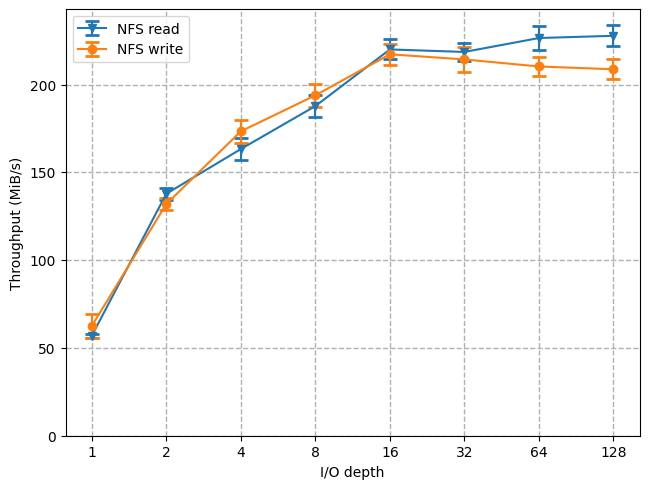

In [6]:
# Throughput
fig, ax = plt.subplots()

BS = '4k'

x = bw.loc[(bw['RW'] == 'randread') & (bw['BS'] == BS), 'QD']
read_avg = bw.loc[(bw['RW'] == 'randread') & (bw['BS'] == BS), 'avg']
read_stdev = bw.loc[(bw['RW'] == 'randread') & (bw['BS'] == BS), 'stdev']
write_avg = bw.loc[(bw['RW'] == 'randwrite') & (bw['BS'] == BS), 'avg']
write_stdev = bw.loc[(bw['RW'] == 'randwrite') & (bw['BS'] == BS), 'stdev']

ax.errorbar(x, read_avg, read_stdev, markersize=6, marker='v', label="NFS read", capsize=5, capthick=2)
ax.errorbar(x, write_avg, write_stdev, markersize=6, marker='o', label="NFS write", capsize=5, capthick=2)

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
ax.legend(loc='best')
ax.set_ylim(bottom=0)
ax.set_ylabel("Throughput (MiB/s)")
ax.set_xlabel("I/O depth")

fig.show()

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_4419/3279510685.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


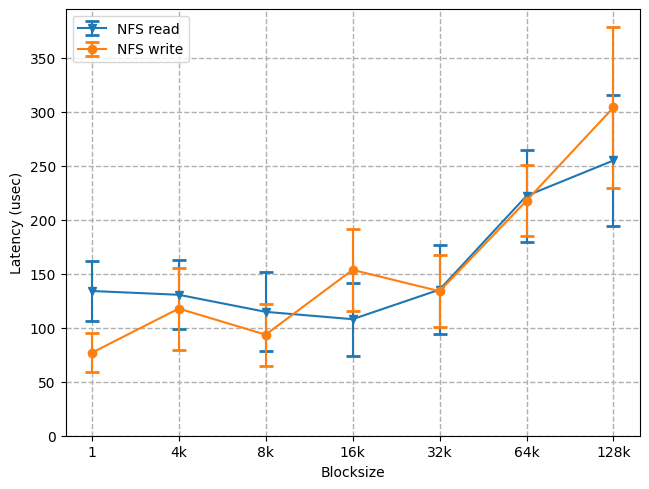

In [7]:
# Latency

fig, ax = plt.subplots()

QD = '1'

x = clat.loc[(clat['RW'] == 'randread') & (clat['QD'] == QD), 'BS']
read_avg = clat.loc[(clat['RW'] == 'randread') & (clat['QD'] == QD), 'avg']
read_stdev = clat.loc[(clat['RW'] == 'randread') & (clat['QD'] == QD), 'stdev']
write_avg = clat.loc[(clat['RW'] == 'randwrite') & (clat['QD'] == QD), 'avg']
write_stdev = clat.loc[(clat['RW'] == 'randwrite') & (clat['QD'] == QD), 'stdev']

ax.errorbar(x, read_avg, read_stdev, markersize=6, marker='v', label="NFS read", capsize=5, capthick=2)
ax.errorbar(x, write_avg, write_stdev, markersize=6, marker='o', label="NFS write", capsize=5, capthick=2)

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
ax.legend(loc='best')
ax.set_ylim(bottom=0)
ax.set_ylabel("Latency (usec)")
ax.set_xlabel("Blocksize")

fig.show()

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_4419/3801642852.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


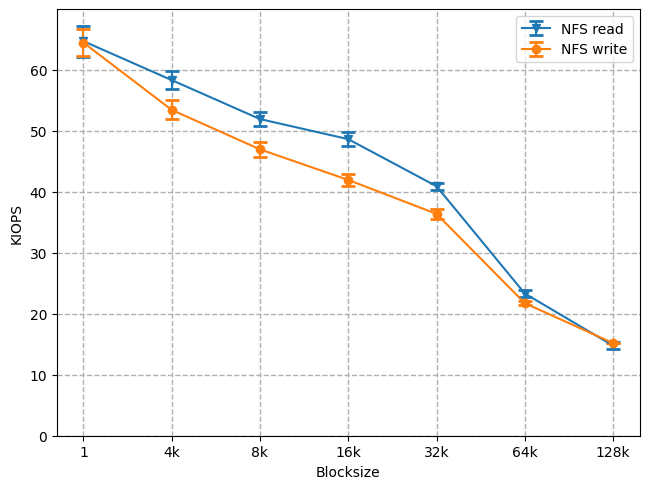

In [8]:
# IOPS

fig, ax = plt.subplots()

QD = '128'

x = iops.loc[(iops['RW'] == 'randread') & (iops['QD'] == QD), 'BS']
read_avg = iops.loc[(iops['RW'] == 'randread') & (iops['QD'] == QD), 'avg'] / 1000
read_stdev = iops.loc[(iops['RW'] == 'randread') & (iops['QD'] == QD), 'stdev'] / 1000
write_avg = iops.loc[(iops['RW'] == 'randwrite') & (iops['QD'] == QD), 'avg'] / 1000
write_stdev = iops.loc[(iops['RW'] == 'randwrite') & (iops['QD'] == QD), 'stdev'] / 1000

ax.errorbar(x, read_avg, write_stdev, markersize=6, marker='v', label="NFS read", capsize=5, capthick=2)
ax.errorbar(x, write_avg, read_stdev, markersize=6, marker='o', label="NFS write", capsize=5, capthick=2)

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
ax.legend(loc='best')
ax.set_ylim(bottom=0)
ax.set_ylabel("KIOPS")
ax.set_xlabel("Blocksize")

fig.show()

63     2
71     2
79     2
87     2
95     2
103    2
111    2
Name: P, dtype: object


ValueError: 'x' and 'y' must have the same size

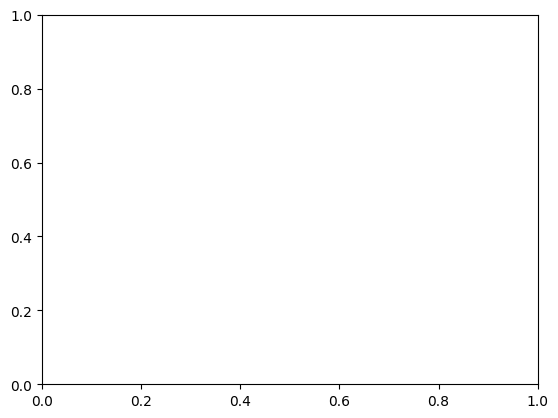

In [11]:
# Throughput

fig, ax = plt.subplots()

QD = '128'
BS = '32k'

x = iops.loc[(iops['RW'] == 'randwrite') & (iops['QD'] == QD), 'P']
print(x)
read_avg = iops.loc[(iops['RW'] == 'randread') & (iops['QD'] == QD) & (iops['BS'] == BS), 'avg']
read_stdev = iops.loc[(iops['RW'] == 'randread') & (iops['QD'] == QD) & (iops['BS'] == BS), 'stdev']
write_avg = iops.loc[(iops['RW'] == 'randwrite') & (iops['QD'] == QD) & (iops['BS'] == BS), 'avg']
write_stdev = iops.loc[(iops['RW'] == 'randwrite') & (iops['QD'] == QD) & (iops['BS'] == BS), 'stdev']

ax.errorbar(x, read_avg, write_stdev, markersize=6, marker='v', label="NFS read", capsize=5, capthick=2)
ax.errorbar(x, write_avg, read_stdev, markersize=6, marker='o', label="NFS write", capsize=5, capthick=2)

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
ax.legend(loc='best')
ax.set_ylim(bottom=0)
ax.set_ylabel("Throughput (MiB/s)")
ax.set_xlabel("Fio thread count")

fig.show()